In [289]:
from bs4 import BeautifulSoup
import re
import requests
import pandas as pd
import json
import csv
import os
import time


%matplotlib inline 

import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 50)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [239]:
InteractiveShell.ast_node_interactivity = "last_expr"

## Data Retrieval

In [233]:
person_ids = {}
player_bios = []

def get_player_bio(person_id):
    
    if person_id in person_ids:
        
        continue
        
    else:

        url = 'https://stats.nba.com/player/' + str(person_id) + '/career/'
        req = requests.get(url)
        soup = BeautifulSoup(req.content)
        player_info = soup.find(text=re.compile('window.nbaStatsPlayerStats'));
        attributes = player_info[player_info.index('{') + 1:player_info.index('}')].split(',"')

        player_bio = {}

        for attribute in attributes:
            key = attribute.split(':')[0].replace('"', '')
            value = attribute.split(':')[1].replace('"', '')
            player_bio[key] = value

        player_bios.append(player_bio)

        person_ids[person_id] = True
            
    return

print(player_bios)

now got Kareem Abdul-Jabbar
now got Tyson Chandler
already got this one
[{'PERSON_ID': '76003', 'FIRST_NAME': 'Kareem', 'LAST_NAME': 'Abdul-Jabbar', 'DISPLAY_FIRST_LAST': 'Kareem Abdul-Jabbar', 'DISPLAY_LAST_COMMA_FIRST': 'Abdul-Jabbar, Kareem', 'DISPLAY_FI_LAST': 'K. Abdul-Jabbar', 'PLAYER_SLUG': 'kareem-abdul-jabbar', 'BIRTHDATE': '1947-04-16T00', 'SCHOOL': 'California-Los Angeles', 'COUNTRY': 'USA', 'LAST_AFFILIATION': 'UCLA\\/USA', 'HEIGHT': '7-2', 'WEIGHT': '225', 'SEASON_EXP': '19', 'JERSEY': '33', 'POSITION': 'Center', 'ROSTERSTATUS': 'Inactive', 'TEAM_ID': '1610612747', 'TEAM_NAME': 'Lakers', 'TEAM_ABBREVIATION': 'LAL', 'TEAM_CODE': 'lakers', 'TEAM_CITY': 'Los Angeles', 'PLAYERCODE': 'HISTADD_kareem_abdul-jabbar', 'FROM_YEAR': '1969', 'TO_YEAR': '1988', 'DLEAGUE_FLAG': 'N', 'NBA_FLAG': 'Y', 'GAMES_PLAYED_FLAG': 'Y', 'DRAFT_YEAR': '1969', 'DRAFT_ROUND': '1', 'DRAFT_NUMBER': '1', 'POSITION_INITIALS': 'C', 'AGE': '73', 'AGE_DAYS': '104'}, {'PERSON_ID': '2199', 'FIRST_NAME': 'Tyson

In [417]:
# Player statistics by season

if not os.path.isdir('./player_data'):
    
    os.makedirs('./player_data', exist_ok=True)
    
    person_ids = {} # will contain person_id for every player in history
    
    # Iterate through seasons.
    
    for i in range (1946, 2020):

        print ('Working on {}'.format(i))
        
        #no data for these years
        if i in [1946, 1947, 1948, 1949, 1950]:
            continue

        time.sleep(3)

        # Get URL
        url_year_part = str(i) + '-' + str(i + 1)[-2:]
        url = 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=' + url_year_part + '&SeasonType=Regular+Season&StatCategory=MIN'

        headers = {
            'referrer': 'https://google.com',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Encoding': 'gzip, deflate, br',
            'Accept-Language': 'en-US,en;q=0.9',
            'Connection': 'keep-alive',
            'DNT': '1',
            'Host': 'stats.nba.com',
            'Referer': 'https://stats.nba.com/leaders/?Season=1950-51&SeasonType=Regular%20Season&StatCategory=MIN',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-origin',
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'x-nba-stats-origin': 'stats',
            'x-nba-stats-token': 'true',
            'X-NewRelic-ID': 'VQECWF5UChAHUlNTBwgBVw=='
            }

        req = requests.get(url, headers=headers)
        stat_dict = json.loads(req.content)
        
        csv_path = 'player_data/' + url_year_part + '.csv'
        csv_columns = stat_dict['resultSet']['headers']
        player_rows = stat_dict['resultSet']['rowSet']
        
        with open(csv_path, 'w') as csvfile:
            
            writer = csv.writer(csvfile)
            writer.writerow(csv_columns)
            
            for row in player_rows:
                writer.writerow(row)
                person_id = row[0]
                if person_id not in person_ids:
                    person_ids[person_id] = True
        
# Writes all player bio information to CSV
    player_bios = []
    player_bio_headers = []

    for person_id in person_ids:
        
        time.sleep(.25)

        url = 'https://stats.nba.com/player/' + str(person_id) + '/career/'
        req = requests.get(url)
        soup = BeautifulSoup(req.content)
        player_info = soup.find(text=re.compile('window.nbaStatsPlayerStats'));
        attributes = player_info[player_info.index('{') + 1:player_info.index('}')].split(',"')

        player_bio = []

        for attribute in attributes:
            attribute_name = attribute.split(':')[0].replace('"', '')
            attribute_value = attribute.split(':')[1].replace('"', '')

            # header row for player_bios.csv
            if len(player_bios) == 0:
                player_bio_headers.append(attribute_name)

            # height as inches int
            if attribute_name == 'HEIGHT':
                height_parts = attribute_value.split('-')
                attribute_value = int(height_parts[0]) * 12 + int(height_parts[1])

            player_bio.append(attribute_value)
            
        player_bios.append(player_bio)

    csv_path = 'player_bios.csv'
    with open(csv_path, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(player_bio_headers)
        for row in player_bios:
            writer.writerow(row)

Working on 2019


121

118

119

114

115

122

117

118

117

118

116

115

129

120

122

116

117

114

118

114

118

120

115

119

121

118

118

118

118

118

117

120

118

117

118

122

121

115

118

121

116

118

116

117

117

118

120

122

116

118

117

120

118

115

114

114

117

116

123

118

116

117

122

122

119

115

121

120

121

128

118

114

123

114

120

115

121

121

121

115

121

113

120

120

121

123

116

114

118

114

118

121

116

116

122

116

120

118

119

119

120

124

123

118

116

114

121

111

120

119

118

120

116

119

117

115

117

117

117

116

116

115

117

119

124

121

115

115

117

117

116

121

117

126

119

117

120

116

116

116

114

114

116

119

116

118

117

117

114

119

118

121

114

116

117

119

116

118

122

121

120

120

115

116

121

119

113

117

115

116

119

117

116

118

113

118

117

119

115

120

114

117

119

119

118

118

117

114

122

120

115

116

118

116

118

122

117

117

119

113

115

114

114

117

128

115

115

118

115

114

114

115

118

111

116

117

117

117

113

115

118

122

116

115

116

115

115

116

117

117

111

114

113

117

115

120

118

117

115

116

119

118

123

120

117

118

118

118

118

116

113

122

113

112

117

114

114

116

118

117

120

112

114

115

working on 203081
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
got here
working on 201935
working on 200768
working on 203468
working on 201566
working on 1626164
working on 1627832
working on 203078
working on 1627783
working on 1627732
working on 1629027
working on 1628983
working on 1628984
working on 1627734
working on 2544
working on 201950
working on 203897
working on 203084
working on 200782
working on 202699
working on 1626162
working on 203497
working on 203952
working on 1628378
working on 1628369
working on 203076
working on 1626179
working on 201942
working on 1628389
working on 202710
working on 1627742
working on 1627759
working on 1629029
working on 202330
working on 200746
working on 202711
working on 203115
working on 162

'                    \n        # need header row for player_bios\n        if len(player_bios) == 0:\n            player_bio_headers = []\n            for attribute in attributes:\n                attribute_name = attribute.split(\':\')[0].replace(\'"\', \'\')\n                player_bio_headers.append(attribute_name)\n\n        for attribute in attributes:\n            attribute_value = attribute.split(\':\')[1].replace(\'"\', \'\')\n            player_bio.append(attribute_value)\n    '

['PERSON_ID', 'FIRST_NAME', 'LAST_NAME', 'DISPLAY_FIRST_LAST', 'DISPLAY_LAST_COMMA_FIRST', 'DISPLAY_FI_LAST', 'PLAYER_SLUG', 'BIRTHDATE', 'SCHOOL', 'COUNTRY', 'LAST_AFFILIATION', 'HEIGHT', 'WEIGHT', 'SEASON_EXP', 'JERSEY', 'POSITION', 'ROSTERSTATUS', 'TEAM_ID', 'TEAM_NAME', 'TEAM_ABBREVIATION', 'TEAM_CODE', 'TEAM_CITY', 'PLAYERCODE', 'FROM_YEAR', 'TO_YEAR', 'DLEAGUE_FLAG', 'NBA_FLAG', 'GAMES_PLAYED_FLAG', 'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER', 'POSITION_INITIALS', 'AGE', 'AGE_DAYS']


392

247

236

217

225

245

220

264

222

260

259

225

328

251

266

240

225

218

252

212

236

243

214

247

244

225

241

232

232

225

222

236

237

237

233

257

255

217

248

249

240

231

248

221

240

227

237

261

211

243

235

259

220

224

232

222

227

214

275

267

248

228

245

249

258

221

249

249

240

282

259

256

256

234

285

222

259

260

275

238

264

258

246

258

256

290

230

227

244

217

254

264

240

256

266

254

229

273

248

223

249

292

263

226

242

223

234

210

259

274

242

255

278

238

250

217

251

224

227

236

220

216

225

244

278

259

208

238

221

222

253

274

236

291

258

268

245

253

288

269

234

209

230

241

223

221

210

263

230

229

250

233

219

228

222

243

262

273

271

283

261

291

231

221

264

274

223

275

246

245

255

229

233

254

219

252

222

249

232

249

216

227

272

245

259

258

241

222

271

253

218

239

241

238

254

258

279

260

279

260

232

211

232

252

291

231

239

249

236

221

245

216

265

209

274

244

249

261

217

248

233

278

242

227

262

226

233

235

282

269

230

244

207

254

226

270

255

240

237

241

276

255

272

264

256

251

266

264

259

249

242

318

220

247

227

223

249

266

252

230

253

215

242

249

In [418]:
pd.read_csv('player_bios_test.csv').head()

,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,POSITION_INITIALS,AGE,AGE_DAYS
0,203081,Damian,Lillard,Damian Lillard,"Lillard, Damian",D. Lillard,damian-lillard,1990-07-15T00,Weber State,USA,Weber State\/USA,74,195,7,0,Guard,Active,1610612757,Trail Blazers,POR,blazers,Portland,damian_lillard,2012,2019,N,Y,Y,2012,1,6,G,30,22
1,201935,James,Harden,James Harden,"Harden, James",J. Harden,james-harden,1989-08-26T00,Arizona State,USA,Arizona State\/USA,77,220,10,13,Guard,Active,1610612745,Rockets,HOU,rockets,Houston,james_harden,2009,2019,N,Y,Y,2009,1,3,G,30,346
2,200768,Kyle,Lowry,Kyle Lowry,"Lowry, Kyle",K. Lowry,kyle-lowry,1986-03-25T00,Villanova,USA,Villanova\/USA,72,196,13,7,Guard,Active,1610612761,Raptors,TOR,raptors,Toronto,kyle_lowry,2006,2019,N,Y,Y,2006,1,24,G,34,134
3,203468,CJ,McCollum,CJ McCollum,"McCollum, CJ",C. McCollum,cj-mccollum,1991-09-19T00,Lehigh,USA,Lehigh\/USA,75,190,6,3,Guard,Active,1610612757,Trail Blazers,POR,blazers,Portland,cj_mccollum,2013,2019,Y,Y,Y,2013,1,10,G,28,322
4,201566,Russell,Westbrook,Russell Westbrook,"Westbrook, Russell",R. Westbrook,russell-westbrook,1988-11-12T00,UCLA,USA,UCLA\/USA,75,200,11,0,Guard,Active,1610612745,Rockets,HOU,rockets,Houston,russell_westbrook,2008,2019,N,Y,Y,2008,1,4,G,31,268


## Clustering Runs

In [279]:
InteractiveShell.ast_node_interactivity = "last_expr"

years = [x for x in os.listdir(path='./player_data') if x[-4:] == '.csv']
years.sort()

# initializing K-Means Results list, with header row
results = [['year', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']]

# initializing player statistics
player_stats = [['year', 'PLAYER_ID', 'player', 'GP', 'MIN', 'PTS', 'REB', 'AST']]

#initializing player clusters
player_clusters = [['year', 'PLAYER_ID', 'player', 'n_clusters', 'cluster']]

# initializing centroid statistics
centroid_stats = [['year', 'n_clusters', 'cluster', 'n_players', 'PTS', 'REB', 'AST']]

# year by year
for year in range(1951, 2020):
#for year in range(2019, 2020):    
    
    print('Working on {}...'.format(year))
    
    df = pd.read_csv('./player_data/' + str(year) + '-' + str(year + 1)[-2:] + '.csv')
    df = df[df.MIN >= 25]
    df.insert(0, 'year', year)
        
    cols = ['year', 'PLAYER_ID', 'PLAYER', 'GP', 'MIN']
    k_means_attributes = ['PTS', 'REB', 'AST']
    cols.extend(k_means_attributes)
    
    # Per 36 stats for K-Means attributes
    # Steals, Blocks start in 1973
    per_36 = df.loc[:,cols]
    for attrib in k_means_attributes:
        per_36.loc[:, attrib] = (per_36[attrib] * (36 / per_36['MIN'])).round(1)
    
    # per_36 dataframe to equalize minutes for K-Means. Also storing as separate file
    player_stats.extend(per_36.to_records(index=False).tolist())
    curr_player_clusters = per_36.loc[:,['year', 'PLAYER_ID', 'PLAYER']]
        
    # Checking relationships between pts, reb, ast
    #sns.pairplot(per_36[k_means_attributes])
    
    # Scaling
    scaler = preprocessing.StandardScaler()
    per_36_scaled = scaler.fit_transform(per_36[k_means_attributes])
        
    clusters = list(range(1, 11))
#    clusters = [3, 5]
    inertias = []
    silhouettes = []
    avg_dist_from_centroids = []
    
    for k in clusters:
        
        kmeans = cluster.KMeans(n_clusters=k,
                               init='k-means++', #initializes nodes at greater distance from each other
                               random_state=1)
        kmeans.fit(per_36_scaled)
        
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        inertia = kmeans.inertia_
        #silhouette_score = metrics.silhouette_score(per_36_scaled, labels, metric='euclidean')
        
        # Equalizes inertia metric across different numbers of players in league 
        avg_dist_from_centroid = inertia/len(per_36_scaled)
        
        inertias.append(round(inertia, 1))
        #silhouettes.append(round(silhouette_score, 1))
        avg_dist_from_centroids.append(avg_dist_from_centroid)
            
        curr_player_clusters['n_clusters'] = k
        curr_player_clusters['cluster'] = labels
        player_clusters.extend(curr_player_clusters.to_records(index=False).tolist())
        
        # Players per cluster
        n_players = pd.Series(labels).value_counts().sort_index().tolist()
        
        # Logs unnormalized PTS/REB/AST values for each centroid, so we have frames of reference 
        # for the clusters each player ends up in
        curr_centroid_stats = pd.DataFrame(data=scaler.inverse_transform(centroids),
                                    columns=k_means_attributes).round(1)
        curr_centroid_stats.insert(0, column='year', value=year)
        curr_centroid_stats.insert(1, column='n_clusters', value=k)
        curr_centroid_stats.insert(2, column='label', value=curr_centroid_stats.index)
        curr_centroid_stats.insert(3, column='n_players', value = n_players)
        centroid_stats.extend(curr_centroid_stats.to_records(index=False).tolist()) # maintains data type, no int-->float
    
    #plt.scatter(clusters, inertias)
    #plt.scatter(clusters, silhouettes)
    
    avg_dist_from_centroids.insert(0, year)
    results.append(avg_dist_from_centroids)
        
# results to CSV
csv_path = 'k_means_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for year in results:
        writer.writerow(year)

csv_path = 'player_per_36_stats.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for player_year in player_stats:
        writer.writerow(player_year)
        
csv_path = 'player_clusters.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for player_cluster in player_clusters:
        writer.writerow(player_cluster)
        
csv_path = 'centroid_results.csv'
with open(csv_path, 'w') as csvfile:
    writer = csv.writer(csvfile)
    for centroid in centroid_stats:
        writer.writerow(centroid)

Working on 1951...
Working on 1952...
Working on 1953...
Working on 1954...
Working on 1955...
Working on 1956...
Working on 1957...
Working on 1958...
Working on 1959...
Working on 1960...
Working on 1961...
Working on 1962...
Working on 1963...
Working on 1964...
Working on 1965...
Working on 1966...
Working on 1967...
Working on 1968...
Working on 1969...
Working on 1970...
Working on 1971...
Working on 1972...
Working on 1973...
Working on 1974...
Working on 1975...
Working on 1976...
Working on 1977...
Working on 1978...
Working on 1979...
Working on 1980...
Working on 1981...
Working on 1982...
Working on 1983...
Working on 1984...
Working on 1985...
Working on 1986...
Working on 1987...
Working on 1988...
Working on 1989...
Working on 1990...
Working on 1991...
Working on 1992...
Working on 1993...
Working on 1994...
Working on 1995...
Working on 1996...
Working on 1997...
Working on 1998...
Working on 1999...
Working on 2000...
Working on 2001...
Working on 2002...
Working on 2

## Points of Interest

In [420]:
InteractiveShell.ast_node_interactivity = "all"

k_means_results = pd.read_csv('k_means_results.csv')
k_means_results.tail(10)

player_bios = pd.read_csv('player_bios.csv')
player_bios.tail(10)

centroid_stats = pd.read_csv('centroid_results.csv')
centroid_stats.tail(10)

per_36_stats = pd.read_csv('player_per_36_stats.csv')
per_36_stats.tail(10)

player_clusters = pd.read_csv('player_clusters.csv')
player_clusters.tail(10)

,year,one,two,three,four,five,six,seven,eight,nine,ten
59,2010,3.0,1.988510,1.423049,1.024927,0.877172,0.747680,0.639392,0.570399,0.500388,0.455939
60,2011,3.0,1.956316,1.415952,1.070299,0.864525,0.741967,0.664059,0.581981,0.518607,0.438811
61,2012,3.0,1.857991,1.334355,1.058892,0.840027,0.698127,0.631782,0.577656,0.525035,0.480443
62,2013,3.0,2.028908,1.416437,1.134981,0.918688,0.786887,0.693855,0.643656,0.592282,0.554401
63,2014,3.0,1.960581,1.376792,1.147561,0.939432,0.824221,0.717798,0.653870,0.586990,0.534976
64,2015,3.0,2.033013,1.411041,1.147259,0.981196,0.812118,0.728314,0.656661,0.603640,0.561780
65,2016,3.0,2.081393,1.535089,1.184117,1.000171,0.858613,0.747833,0.644709,0.582667,0.536827
66,2017,3.0,2.117217,1.475977,1.214232,1.003018,0.844201,0.735158,0.662527,0.605430,0.540099
67,2018,3.0,2.070765,1.463222,1.218083,1.036332,0.882865,0.797156,0.722104,0.645587,0.586579
68,2019,3.0,1.963126,1.355083,1.106549,0.913227,0.807359,0.732872,0.676317,0.617683,0.568896


,Unnamed: 0,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,POSITION_INITIALS,AGE,AGE_DAYS
2170,2170,1629022,Lonnie,Walker IV,Lonnie Walker IV,"Walker IV, Lonnie",L. Walker IV,lonnie-walker-iv,1998-12-14T00,Miami,USA,University of Miami\/USA,77.0,204.0,1,1,Guard-Forward,Active,1610612759,Spurs,SAS,spurs,San Antonio,lonnie_walker,2018,2019,Y,Y,Y,2018,1,18,G-F,21,228
2171,2171,1628964,Mo,Bamba,Mo Bamba,"Bamba, Mo",M. Bamba,mo-bamba,1998-05-12T00,University of Texas at Austin,USA,University of Texas at Austin\/USA,84.0,231.0,1,5,Center,Active,1610612753,Magic,ORL,magic,Orlando,mohamed_bamba,2018,2019,N,Y,Y,2018,1,6,C,22,78
2172,2172,1629008,Michael,Porter Jr.,Michael Porter Jr.,"Porter Jr., Michael",M. Porter Jr.,michael-porter-jr,1998-06-29T00,Missouri,USA,University of Missouri\/USA,82.0,218.0,0,1,Forward,Active,1610612743,Nuggets,DEN,nuggets,Denver,michael_porter_jr,2018,2019,N,Y,Y,2018,1,14,F,22,30
2173,2173,1629010,Jerome,Robinson,Jerome Robinson,"Robinson, Jerome",J. Robinson,jerome-robinson,1997-02-22T00,Boston College,USA,Boston College\/USA,76.0,190.0,1,12,Guard,Active,1610612764,Wizards,WAS,wizards,Washington,jerome_robinson,2018,2019,Y,Y,Y,2018,1,13,G,23,158
2174,2174,1628449,Chris,Boucher,Chris Boucher,"Boucher, Chris",C. Boucher,chris-boucher,1993-01-11T00,Oregon,Canada,Oregon\/Canada,81.0,200.0,2,25,Forward-Center,Active,1610612761,Raptors,TOR,raptors,Toronto,chris_boucher,2017,2019,Y,Y,Y,Undrafted,Undrafted,Undrafted,F-C,27,200
2175,2175,1629059,Elie,Okobo,Elie Okobo,"Okobo, Elie",E. Okobo,elie-okobo,1997-10-23T00,,France,Elan Bearnais\/France,75.0,190.0,1,2,Forward-Guard,Active,1610612756,Suns,PHX,suns,Phoenix,elie_okobo,2018,2019,Y,Y,Y,2018,2,31,F-G,22,280
2176,2176,1628981,Bruno,Fernando,Bruno Fernando,"Fernando, Bruno",B. Fernando,bruno-fernando,1998-08-15T00,Maryland,Angola,Maryland\/Angola,81.0,240.0,0,24,Forward-Center,Active,1610612737,Hawks,ATL,hawks,Atlanta,bruno_fernando,2019,2019,Y,Y,Y,2019,2,34,F-C,21,349
2177,2177,1629642,Nassir,Little,Nassir Little,"Little, Nassir",N. Little,nassir-little,2000-02-11T00,North Carolina,USA,University of North Carolina at Cha\/USA,77.0,220.0,0,9,Forward-Guard,Active,1610612757,Trail Blazers,POR,blazers,Portland,nassir_little,2019,2019,N,Y,Y,2019,1,25,F-G,20,169
2178,2178,1628396,Tony,Bradley,Tony Bradley,"Bradley, Tony",T. Bradley,tony-bradley,1998-01-08T00,North Carolina,USA,North Carolina\/USA,82.0,248.0,2,13,Center-Forward,Active,1610612762,Jazz,UTA,jazz,Utah,tony_bradley,2017,2019,Y,Y,Y,2017,1,28,C-F,22,203
2179,2179,1629048,Goga,Bitadze,Goga Bitadze,"Bitadze, Goga",G. Bitadze,goga-bitadze,1999-07-20T00,,Georgia,Mega Basket (Serbia)\/Georgia,83.0,250.0,0,88,Center-Forward,Active,1610612754,Pacers,IND,pacers,Indiana,goga_bitadze,2019,2019,Y,Y,Y,2019,1,18,C-F,21,9


,year,n_clusters,cluster,n_players,PTS,REB,AST
3785,2019,10,0,34,14.1,6.5,2.3
3786,2019,10,1,20,21.2,4.8,7.3
3787,2019,10,2,6,20.3,11.5,4.9
3788,2019,10,3,14,22.9,7.9,2.8
3789,2019,10,4,7,16.8,14.3,2.3
3790,2019,10,5,25,20.7,4.7,3.4
3791,2019,10,6,1,34.5,16.0,6.8
3792,2019,10,7,12,13.6,3.5,2.7
3793,2019,10,8,8,29.7,6.7,7.9
3794,2019,10,9,10,13.3,5.5,5.8


,year,PLAYER_ID,player,GP,MIN,PTS,REB,AST
6685,2019,201565,Derrick Rose,50,26.0,25.1,3.3,7.8
6686,2019,204038,Langston Galloway,66,25.8,14.4,3.2,2.1
6687,2019,1629632,Coby White,65,25.8,18.4,4.9,3.8
6688,2019,1628386,Jarrett Allen,64,25.7,14.8,13.3,1.8
6689,2019,1628467,Maxi Kleber,66,25.7,12.9,7.6,1.7
6690,2019,203484,Kentavious Caldwell-Pope,63,25.5,13.4,3.0,2.4
6691,2019,201980,Danny Green,61,25.1,11.8,4.9,2.0
6692,2019,1627854,Bryn Forbes,63,25.1,16.1,2.9,2.4
6693,2019,203145,Kent Bazemore,64,25.1,12.5,6.2,1.9
6694,2019,1629006,Josh Okogie,62,25.0,12.4,6.2,2.3


,year,PLAYER_ID,player,n_clusters,cluster
66940,2019,201565,Derrick Rose,10,1
66941,2019,204038,Langston Galloway,10,7
66942,2019,1629632,Coby White,10,5
66943,2019,1628386,Jarrett Allen,10,4
66944,2019,1628467,Maxi Kleber,10,0
66945,2019,203484,Kentavious Caldwell-Pope,10,7
66946,2019,201980,Danny Green,10,7
66947,2019,1627854,Bryn Forbes,10,7
66948,2019,203145,Kent Bazemore,10,0
66949,2019,1629006,Josh Okogie,10,0


In [367]:
#temp = player_bios.HEIGHT.str.split('-', expand=True)
#player_bios['HEIGHT'] = pd.to_numeric(temp[0]) * 12 + pd.to_numeric(temp[1])
#player_bios.head()
#player_bios.shape
#player_bios.to_csv('player_bios.csv')
player_bios = pd.read_csv('player_bios.csv')
player_bios.head()

,Unnamed: 0,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,PLAYER_SLUG,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG,NBA_FLAG,GAMES_PLAYED_FLAG,DRAFT_YEAR,DRAFT_ROUND,DRAFT_NUMBER,POSITION_INITIALS,AGE,AGE_DAYS
0,0,76056,Paul,Arizin,Paul Arizin,"Arizin, Paul",P. Arizin,paul-arizin,1928-04-09T00,Villanova,USA,Villanova\/USA,76.0,190.0,9,11,Forward,Inactive,1610612744,Warriors,PHW,warriors,Philadelphia,HISTADD_paul_arizin,1950,1961,N,Y,Y,1950,NaN,NaN,F,92,111
1,1,77853,Andy,Phillip,Andy Phillip,"Phillip, Andy",A. Phillip,andy-phillip,1922-03-07T00,Illinois,USA,Illinois\/USA,75.0,195.0,10,17,Guard,Inactive,1610612765,Pistons,FTW,pistons,Ft. Wayne Zollner,HISTADD_andy_phillip,1947,1957,N,Y,Y,1947,NaN,NaN,G,98,143
2,2,78075,Fred,Schaus,Fred Schaus,"Schaus, Fred",F. Schaus,fred-schaus,1925-06-30T00,West Virginia,USA,West Virginia\/USA,77.0,205.0,4,17,Forward,Inactive,1610612765,Pistons,FTW,pistons,Ft. Wayne Zollner,HISTADD_fred_schaus,1949,1953,N,Y,Y,1949,3,NaN,F,95,29
3,3,600003,Bob,Cousy,Bob Cousy,"Cousy, Bob",B. Cousy,bob-cousy,1928-08-09T00,Holy Cross,USA,Holy Cross\/USA,73.0,175.0,13,14,Guard,Inactive,1610612738,Celtics,BOS,celtics,Boston,HISTADD_bob_cousy,1950,1969,N,Y,Y,1950,1,3,G,91,355
4,4,76250,Frank,Brian,Frank Brian,"Brian, Frank",F. Brian,frank-brian,1923-05-01T00,Louisiana State,USA,Louisiana State\/USA,73.0,180.0,6,7,Guard,Inactive,1610612765,Pistons,FTW,pistons,Ft. Wayne Zollner,HISTADD_flash_brian,1949,1955,N,Y,Y,Undrafted,Undrafted,Undrafted,G,97,89


### Cluster grouping over time

Hopefully, we'll see our metric get closer to zero year over year for our three-cluster K-means runs, meaning that three clusters (point-wing-big) describes the data better over time.

And hopefully, it will get further from zero for our five-cluster K-means runs, as the point-shooting guard-small forward-power forward-center groupings fall out of fashion.

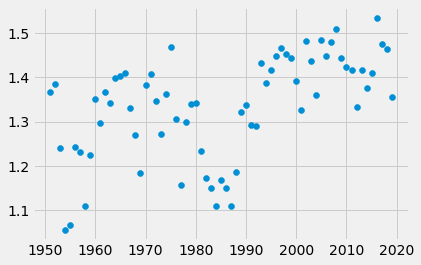

In [378]:
plt.scatter(x=k_means_results['year'], y=k_means_results['three'])

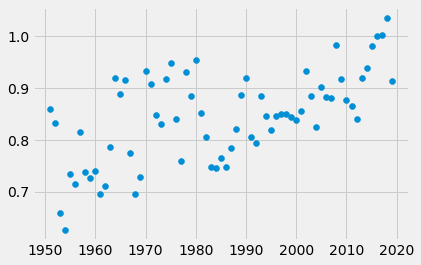

In [379]:
plt.scatter(x=k_means_results['year'], y=k_means_results['five'])

Nope. Cluster fit was scattered through the 70s, then hit a low point in the mid 80s, and has gradually increased in the time since.

### Clusters vs Positions

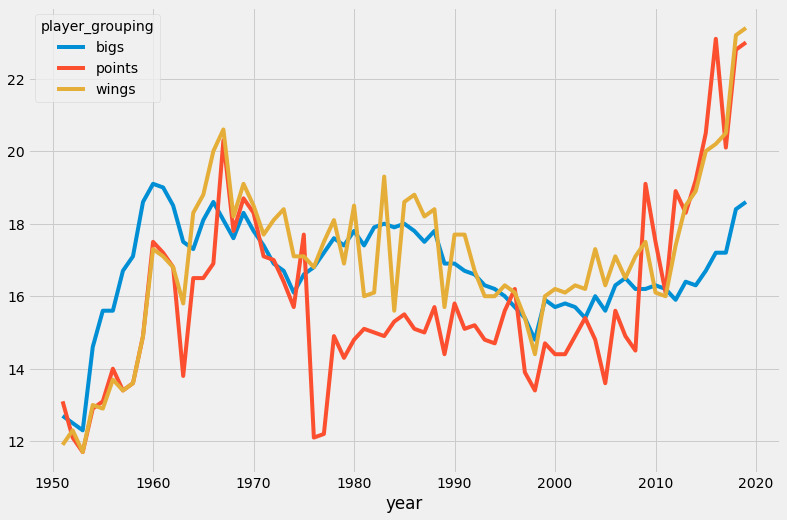

In [403]:
clusters = centroid_stats.merge(player_clusters, left_on=['year', 'n_clusters', 'cluster'], right_on=['year', 'n_clusters', 'cluster'])
player_cluster_combo = clusters.merge(player_bios, left_on=['PLAYER_ID'], right_on=['PERSON_ID'])
#player_cluster_combo.head()

avg_heights = player_cluster_combo.groupby(['year', 'n_clusters', 'cluster'])['HEIGHT'].mean().reset_index().sort_values(['year', 'n_clusters', 'HEIGHT'])
#avg_heights[avg_heights.n_clusters == 3]

all_columns = centroid_stats.merge(avg_heights, left_on=['year', 'n_clusters', 'cluster'], right_on=['year', 'n_clusters', 'cluster'])
all_columns['player_grouping'] = all_columns.groupby(['year', 'n_clusters'])['HEIGHT'].rank(ascending=False).map({1.0: 'bigs', 2.0: 'wings', 3.0: 'points'})
#all_columns[all_columns.n_clusters == 3].sort_values(['year', 'n_clusters', 'player_grouping'])

pivot = all_columns.pivot_table(values='PTS', index='year', columns='player_grouping', aggfunc='first')

pivot.plot(figsize=(12, 8))




### Position vs Group

In [421]:
player_bios.head

<bound method NDFrame.head of       Unnamed: 0  PERSON_ID FIRST_NAME LAST_NAME DISPLAY_FIRST_LAST  \
0              0      76056       Paul    Arizin        Paul Arizin   
1              1      77853       Andy   Phillip       Andy Phillip   
2              2      78075       Fred    Schaus        Fred Schaus   
3              3     600003        Bob     Cousy          Bob Cousy   
4              4      76250      Frank     Brian        Frank Brian   
...          ...        ...        ...       ...                ...   
2175        2175    1629059       Elie     Okobo         Elie Okobo   
2176        2176    1628981      Bruno  Fernando     Bruno Fernando   
2177        2177    1629642     Nassir    Little      Nassir Little   
2178        2178    1628396       Tony   Bradley       Tony Bradley   
2179        2179    1629048       Goga   Bitadze       Goga Bitadze   

     DISPLAY_LAST_COMMA_FIRST DISPLAY_FI_LAST     PLAYER_SLUG      BIRTHDATE  \
0                Arizin, Paul       P

### Exploring year gaps

In [263]:
centroids[(centroids['n_clusters'] == 5) & centroids['year'].isin([1975, 1985, 2005, 2015])].sort_values(['year', 'AST'])

,year,n_clusters,cluster,n_players,PTS,REB,AST
1331,1975,5,1,22,16.5,9.1,2.0
1333,1975,5,3,9,10.7,11.9,3.4
1332,1975,5,2,23,15.0,4.4,3.7
1334,1975,5,4,8,22.7,11.0,3.8
1330,1975,5,0,20,18.7,3.7,5.5
1883,1985,5,3,33,18.4,9.9,2.2
1880,1985,5,0,8,9.5,8.7,2.3
1882,1985,5,2,21,24.0,5.4,3.5
1884,1985,5,4,20,17.7,4.5,4.0
1881,1985,5,1,25,15.4,3.7,8.0


### Cluster Player Representatives

In [265]:

temp = centroids.merge(player_clusters, on=['year', 'n_clusters', 'cluster']).merge(per_36_stats, on=['year', 'player'], suffixes=('_cluster', '_player'))

temp['difference'] = (temp.PTS_cluster - temp.PTS_player).abs() + (temp.REB_cluster - temp.REB_player).abs() + (temp.AST_cluster - temp.AST_player).abs()
temp = temp.sort_values('difference')
#temp.sort_values('year', 'n_clusters', 'AST_cluster', )
temp['ordering'] = temp['AST_cluster'] - temp['REB_cluster']
temp = temp.groupby(['year', 'n_clusters', 'cluster']).head(1).sort_values(['year', 'n_clusters', 'ordering'])

#temp = temp[(temp['n_clusters'] == 5) & (temp['year'] % 4 == 0)]
temp = temp[(temp['n_clusters'] == 3)]
temp


,year,n_clusters,cluster,n_players,PTS_cluster,REB_cluster,AST_cluster,player,GP,MIN,PTS_player,REB_player,AST_player,difference,ordering
292,1951,3,1,23,13.8,10.2,2.5,Don Barksdale,62,32.5,14.0,10.7,2.4,0.8,-7.7
352,1951,3,0,21,11.5,5.1,3.4,Don Boven,66,30.0,11.9,6.1,3.2,1.6,-1.7
422,1951,3,2,7,13.1,4.7,5.7,George King,66,28.6,12.6,5.3,4.7,2.1,1.0
1012,1952,3,2,15,15.6,9.9,2.6,Connie Simmons,65,26.3,15.3,9.6,2.7,0.7,-7.3
832,1952,3,0,16,10.1,8.4,2.4,Bob Lavoy,70,33.2,9.5,8.1,2.1,1.2,-6.0
892,1952,3,1,21,12.1,4.3,3.9,Jim Baechtold,64,29.6,12.5,4.1,2.9,1.6,-0.4
1142,1953,3,2,8,16.5,11.9,2.3,Dolph Schayes,72,36.9,16.7,11.8,2.9,0.9,-9.6
1332,1953,3,0,14,10.8,8.5,2.3,Earl Lloyd,72,30.6,10.7,8.6,1.9,0.6,-6.2
1262,1953,3,1,22,11.7,4.1,4.0,George King,72,32.9,12.4,4.0,4.2,1.0,-0.1
1732,1954,3,2,11,18.2,12.1,2.2,Larry Foust,70,32.3,18.9,11.1,1.9,2.0,-9.9
